In [2]:
import torch
import numpy as np
from typing import Tuple, List
import torch.nn.utils.prune as prune
from sklearn.cluster import KMeans

def compute_eigenfunction_compression(model: torch.nn.Module, k: int) -> Tuple[float, List[float]]:
    """
    Compute compression ratio for sum of top k eigenfunctions using quantization and arithmetic coding
    
    Args:
        model: Neural network model
        k: Number of top eigenfunctions to consider
    
    Returns:
        compression_ratio: Overall compression ratio
        eigenvalue_ratios: List of compression ratios for each eigenvalue
    """
    # Get pruned parameters vector
    vec = get_pruned_vec(model)
    
    # Compute SVD to get eigenfunctions
    U, S, V = torch.svd(vec.reshape(1, -1))
    eigenfunctions = U[:,:k]
    
    # Quantization parameters
    levels = 7  # Number of quantization levels
    
    compression_ratios = []
    total_bits = 0
    
    for i in range(k):
        eigenfunction = eigenfunctions[:,i]
        
        # Get quantization levels using k-means
        kmeans = KMeans(n_clusters=levels).fit(eigenfunction.reshape(-1, 1))
        centroids = kmeans.cluster_centers_.astype(np.float16)[:,0]
        symbols = kmeans.labels_
        
        # Compute probabilities for arithmetic coding
        probabilities = np.array([np.mean(symbols == j) for j in range(levels)])
        
        # Compute entropy for arithmetic coding
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
        
        # Compute compressed size
        n_symbols = len(symbols)
        coded_symbols_size = np.ceil(n_symbols * entropy)
        codebook_size = levels * 16  # 16 bits per centroid
        probability_size = levels * np.ceil(np.log2(n_symbols))
        total_size = coded_symbols_size + codebook_size + probability_size
        
        # Original size (32 bits per value)
        original_size = n_symbols * 32
        
        compression_ratio = total_size / original_size
        compression_ratios.append(compression_ratio)
        total_bits += total_size
        
    return total_bits / (vec.numel() * 32), compression_ratios

def analyze_compression_vs_k(model: torch.nn.Module, max_k: int = 100) -> None:
    """
    Analyze compression ratio vs number of eigenfunctions
    """
    k_values = list(range(1, max_k+1))
    compression_ratios = []
    eigenvalue_ratios = []
    
    for k in k_values:
        ratio, eig_ratios = compute_eigenfunction_compression(model, k)
        compression_ratios.append(ratio)
        eigenvalue_ratios.append(eig_ratios)
    
    # Plot results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    
    plt.subplot(121)
    plt.plot(k_values, compression_ratios)
    plt.xlabel('Number of eigenfunctions (k)')
    plt.ylabel('Compression ratio')
    plt.title('Overall Compression vs k')
    plt.yscale('log')
    
    plt.subplot(122)
    for i in range(min(5, max_k)):
        ratios = [r[i] if i < len(r) else None for r in eigenvalue_ratios]
        plt.plot(k_values[:len(ratios)], ratios, label=f'Eigenfunction {i+1}')
    plt.xlabel('k')
    plt.ylabel('Compression ratio') 
    plt.title('Individual Eigenfunction Compression')
    plt.legend()
    plt.yscale('log')
    
    plt.tight_layout()
    plt.savefig('compression_analysis.png')
    plt.close()

In [6]:
def analyze_model_compression(model_path: str, n_train: int):
    # Load model
    model = torch.load(model_path)
    
    # Analyze compression
    analyze_compression_vs_k(model, max_k=100)
    
    # Get compression ratio for optimal k
    ratio, _ = compute_eigenfunction_compression(model, k=10)
    print(f"Compression ratio for n={n_train}: {ratio:.3f}")

analyze_model_compression("/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved/train_dataset_h1000_d4_n20000_lr0.005_g1.0_mup_pennington_20250125_153135_rank0.pt",20000)

/tmp/ipykernel_2702738/1734831478.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


NameError: name 'get_pruned_vec' is not defined

Loading model from /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved/train_dataset_h1000_d4_n20000_lr0.005_g1.0_mup_pennington_20250125_153135_rank0.pt
Loaded parameters with shape: torch.Size([20000, 30])


/tmp/ipykernel_2702738/137197874.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(model_path)


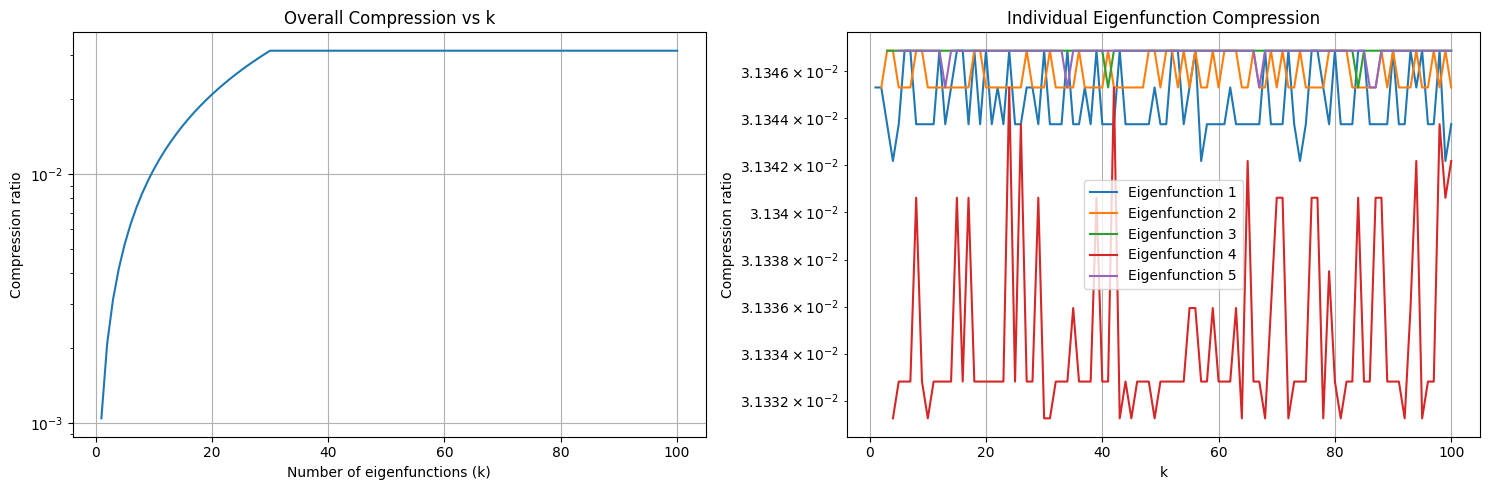

Compression ratio for n=20000: 0.010


In [9]:
import torch
import numpy as np
from typing import Tuple, List
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
def compute_eigenfunction_compression(parameters: torch.Tensor, k: int) -> Tuple[float, List[float]]:
    # Ensure parameters are on CPU and reshape
    parameters = parameters.cpu()
    matrix = parameters.reshape(parameters.shape[0], -1)
    
    # Compute SVD
    try:
        U, S, V = torch.svd(matrix)
        eigenfunctions = U[:,:min(k, U.shape[1])]
    except RuntimeError:
        print(f"SVD failed. Input shape: {matrix.shape}")
        raise
    
    # Reduce number of quantization levels
    levels = 2  # Changed from 7 to 2 since data seems binary
    
    compression_ratios = []
    total_bits = 0
    
    for i in range(min(k, eigenfunctions.shape[1])):
        eigenfunction = eigenfunctions[:,i].numpy().reshape(-1, 1)
        
        # Get quantization levels using k-means
        kmeans = KMeans(n_clusters=levels, n_init=10).fit(eigenfunction)
        centroids = kmeans.cluster_centers_.astype(np.float16)[:,0]
        symbols = kmeans.labels_
        
        # Compute probabilities and entropy
        probabilities = np.array([np.mean(symbols == j) for j in range(levels)])
        probabilities = probabilities[probabilities > 0]
        entropy = -np.sum(probabilities * np.log2(probabilities))
        
        # Compute sizes
        n_symbols = len(symbols)
        coded_symbols_size = np.ceil(n_symbols * entropy)
        codebook_size = levels * 16
        probability_size = levels * np.ceil(np.log2(n_symbols))
        total_size = coded_symbols_size + codebook_size + probability_size
        
        original_size = n_symbols * 32
        compression_ratio = total_size / original_size
        compression_ratios.append(compression_ratio)
        total_bits += total_size
        
    return total_bits / (parameters.numel() * 32), compression_ratios

def analyze_compression_vs_k(parameters: torch.Tensor, max_k: int = 100) -> None:
    k_values = list(range(1, max_k+1))
    compression_ratios = []
    eigenvalue_ratios = []
    
    for k in k_values:
        ratio, eig_ratios = compute_eigenfunction_compression(parameters, k)
        compression_ratios.append(ratio)
        eigenvalue_ratios.append(eig_ratios)
    
    plt.figure(figsize=(15,5))
    
    # Overall compression plot
    plt.subplot(121)
    plt.plot(k_values, compression_ratios)
    plt.xlabel('Number of eigenfunctions (k)')
    plt.ylabel('Compression ratio')
    plt.title('Overall Compression vs k')
    plt.yscale('log')
    plt.grid(True)
    
    # Individual eigenfunction compression
    plt.subplot(122)
    for i in range(min(5, max_k)):
        ratios = [r[i] if i < len(r) else None for r in eigenvalue_ratios]
        valid_k = [k for k, r in zip(k_values, ratios) if r is not None]
        valid_r = [r for r in ratios if r is not None]
        plt.plot(valid_k, valid_r, label=f'Eigenfunction {i+1}')
    plt.xlabel('k')
    plt.ylabel('Compression ratio')
    plt.title('Individual Eigenfunction Compression')
    plt.legend()
    plt.yscale('log')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()  # Added plt.show()
    plt.savefig('compression_analysis.png')
    plt.close()

def analyze_model_compression(model_path: str, n_train: int):
    """
    Analyze compression of a saved model
    """
    print(f"Loading model from {model_path}")
    
    try:
        # Load saved data
        data = torch.load(model_path)
        
        # Extract X tensor
        if isinstance(data, dict) and 'X' in data:
            parameters = data['X']
        else:
            parameters = data
            
        print(f"Loaded parameters with shape: {parameters.shape}")
        
        # Analyze compression
        analyze_compression_vs_k(parameters, max_k=100)
        
        # Get compression ratio for optimal k
        ratio, _ = compute_eigenfunction_compression(parameters, k=10)
        print(f"Compression ratio for n={n_train}: {ratio:.3f}")
        
    except Exception as e:
        print(f"Error analyzing model: {e}")
        raise

if __name__ == "__main__":
    model_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved/train_dataset_h1000_d4_n20000_lr0.005_g1.0_mup_pennington_20250125_153135_rank0.pt"
    analyze_model_compression(model_path, 20000)

Loading model from /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved/final_model_h1000_d4_n20000_lr0.005_g1.0_mup_pennington_20250125_153135_rank0.pt
Loading training data from /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved/train_dataset_h1000_d4_n20000_lr0.005_g1.0_mup_pennington_20250125_153135_rank0.pt
Loaded parameters with shape: torch.Size([3031000])
Loaded training data with shape: torch.Size([20000, 30])


/tmp/ipykernel_2702738/3706250756.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_path)
/tmp/ipykernel_2702738/3706250756.py:143: FutureW

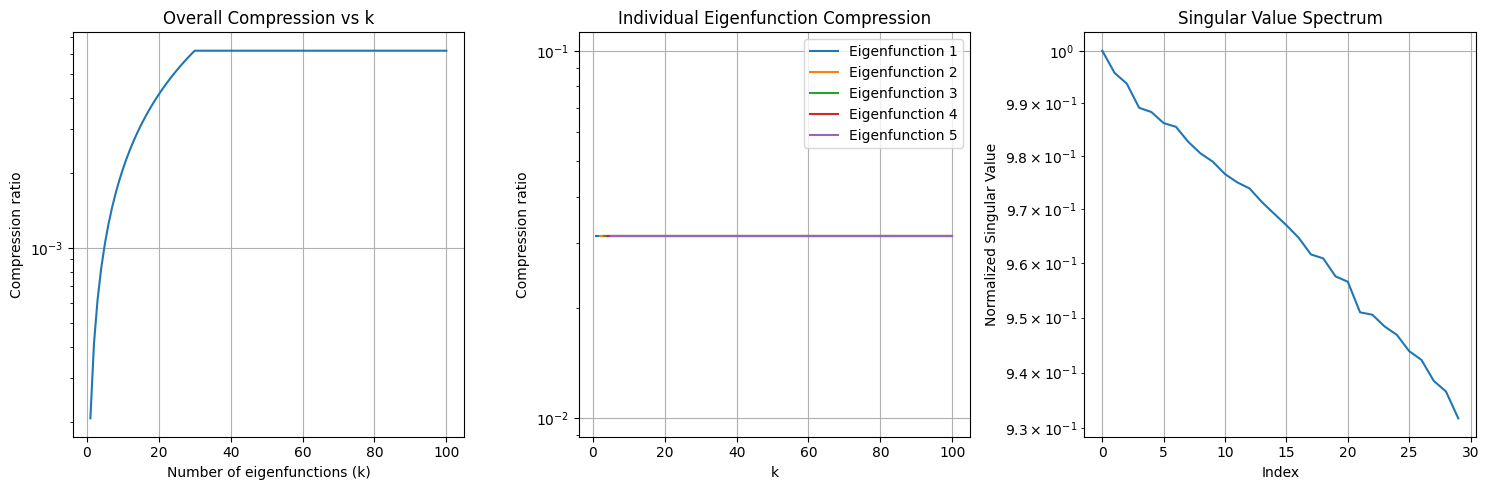

Compression ratio for n=20000: 0.002


In [ ]:
import torch 
import numpy as np
from typing import Tuple, List
import matplotlib.pyplot as plt
from scipy.stats import entropy

def get_model_parameters(model_dict: dict) -> torch.Tensor:
    """Extract and flatten all weights from the model"""
    parameters = []
    for key in model_dict:
        if 'weight' in key:
            parameters.append(model_dict[key].flatten())
    return torch.cat(parameters)

def binary_entropy(p):
    """Compute binary entropy"""
    if p == 0 or p == 1:
        return 0
    return -(p * np.log2(p) + (1-p) * np.log2(1-p))

def compute_binary_compression(eigenfunction: np.ndarray) -> Tuple[float, float]:
    """
    Compute compression ratio for binary data.
    Returns compression ratio and bits needed.
    """
    # Count proportion of 1s (or -1s)
    p = np.mean(eigenfunction > 0)
    
    # Compute entropy
    H = binary_entropy(p)
    
    # Total bits needed:
    n_symbols = len(eigenfunction)
    coded_symbols_size = np.ceil(n_symbols * H)  # Bits for encoded data
    probability_size = np.ceil(np.log2(n_symbols))  # Bits to store p
    total_bits = coded_symbols_size + probability_size
    
    # Original size (32 bits per value)
    original_size = n_symbols * 32
    
    return total_bits / original_size, total_bits

def compute_eigenfunction_compression(parameters: torch.Tensor, 
                                   train_data: torch.Tensor,
                                   k: int) -> Tuple[float, List[float]]:
    """
    Compute compression ratio for sum of top k eigenfunctions
    using the training data to compute SVD
    """
    # Ensure data is on CPU and correctly shaped
    train_data = train_data.cpu()
    parameters = parameters.cpu()
    
    # Compute SVD on training data
    try:
        U, S, V = torch.svd(train_data)
        eigenfunctions = U[:,:min(k, U.shape[1])]
    except RuntimeError:
        print(f"SVD failed. Input shape: {train_data.shape}")
        raise
    
    compression_ratios = []
    total_bits = 0
    
    # For each eigenfunction
    for i in range(min(k, eigenfunctions.shape[1])):
        eigenfunction = eigenfunctions[:,i].numpy()
        ratio, bits = compute_binary_compression(eigenfunction)
        compression_ratios.append(ratio)
        total_bits += bits
        
    return total_bits / (parameters.numel() * 32), compression_ratios

def analyze_compression_vs_k(parameters: torch.Tensor, 
                           train_data: torch.Tensor,
                           max_k: int = 100) -> None:
    """
    Analyze compression ratio vs number of eigenfunctions
    """
    k_values = list(range(1, max_k+1))
    compression_ratios = []
    eigenvalue_ratios = []
    
    # Compute singular values for analysis
    _, S, _ = torch.svd(train_data)
    singular_values = S.cpu().numpy()
    
    for k in k_values:
        ratio, eig_ratios = compute_eigenfunction_compression(parameters, train_data, k)
        compression_ratios.append(ratio)
        eigenvalue_ratios.append(eig_ratios)
    
    plt.figure(figsize=(15,5))
    
    # Overall compression plot
    plt.subplot(131)
    plt.plot(k_values, compression_ratios)
    plt.xlabel('Number of eigenfunctions (k)')
    plt.ylabel('Compression ratio')
    plt.title('Overall Compression vs k')
    plt.yscale('log')
    plt.grid(True)
    
    # Individual eigenfunction compression
    plt.subplot(132)
    for i in range(min(5, max_k)):
        ratios = [r[i] if i < len(r) else None for r in eigenvalue_ratios]
        valid_k = [k for k, r in zip(k_values, ratios) if r is not None]
        valid_r = [r for r in ratios if r is not None]
        plt.plot(valid_k, valid_r, label=f'Eigenfunction {i+1}')
    plt.xlabel('k')
    plt.ylabel('Compression ratio')
    plt.title('Individual Eigenfunction Compression')
    plt.legend()
    plt.yscale('log')
    plt.grid(True)
    
    # Singular value spectrum
    plt.subplot(133)
    plt.plot(singular_values[:50] / singular_values[0])
    plt.xlabel('Index')
    plt.ylabel('Normalized Singular Value')
    plt.title('Singular Value Spectrum')
    plt.yscale('log')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def analyze_model_compression(model_path: str, data_path: str, n_train: int):
    """
    Analyze compression of a model using both model weights and its training data
    """
    print(f"Loading model from {model_path}")
    print(f"Loading training data from {data_path}")
    
    try:
        # Load model parameters
        model_dict = torch.load(model_path)
        parameters = get_model_parameters(model_dict)
            
        # Load training data
        data_dict = torch.load(data_path)
        train_data = data_dict['X']
            
        print(f"Loaded parameters with shape: {parameters.shape}")
        print(f"Loaded training data with shape: {train_data.shape}")
        
        # Analyze compression
        analyze_compression_vs_k(parameters, train_data, max_k=100)
        
        # Get compression ratio for optimal k
        ratio, _ = compute_eigenfunction_compression(parameters, train_data, k=10)
        print(f"Compression ratio for n={n_train}: {ratio:.3f}")
        
    except Exception as e:
        print(f"Error analyzing model: {e}")
        raise

# Example usage:
if __name__ == "__main__":
    model_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved/final_model_h1000_d4_n20000_lr0.005_g1.0_mup_pennington_20250125_153135_rank0.pt"
    data_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved/train_dataset_h1000_d4_n20000_lr0.005_g1.0_mup_pennington_20250125_153135_rank0.pt"
    analyze_model_compression(model_path, data_path, 20000)


   

Loading model from /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved/final_model_h1000_d4_n20000_lr0.005_g1.0_mup_pennington_shuffled_20250125_153042_rank0.pt
Loading training data from /mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved/train_dataset_h1000_d4_n20000_lr0.005_g1.0_mup_pennington_shuffled_20250125_153042_rank0.pt
Loaded parameters with shape: torch.Size([3031000])
Loaded training data with shape: torch.Size([20000, 30])


/tmp/ipykernel_2702738/3706250756.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_path)
/tmp/ipykernel_2702738/3706250756.py:143: FutureW

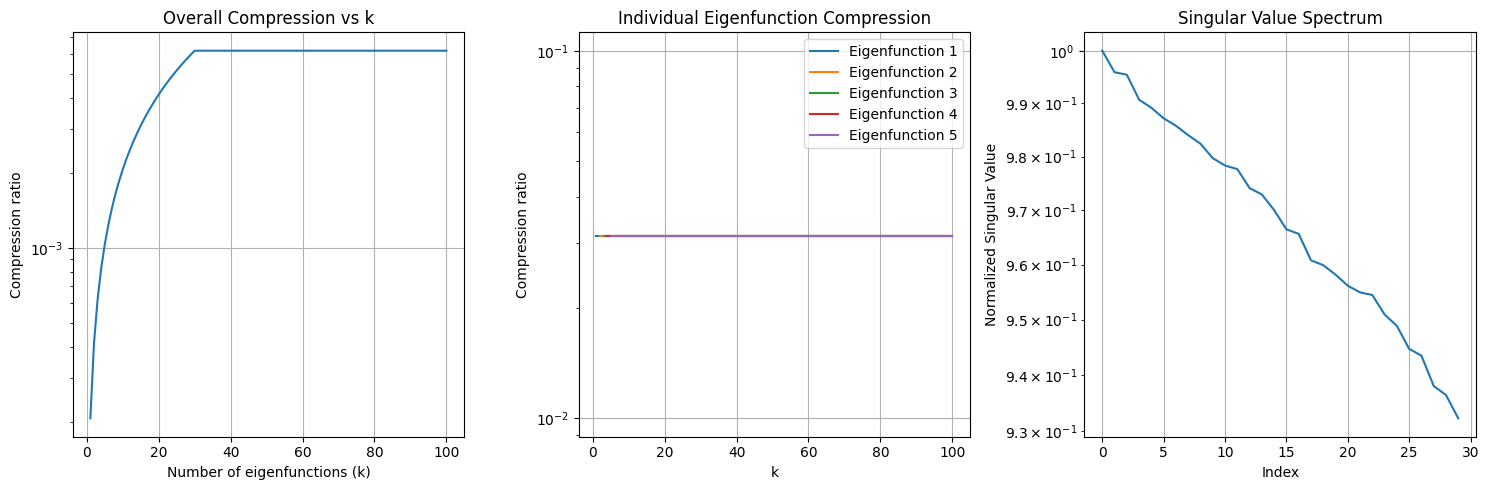

Compression ratio for n=20000: 0.002


In [25]:
model_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved/final_model_h1000_d4_n20000_lr0.005_g1.0_mup_pennington_shuffled_20250125_153042_rank0.pt"
data_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved/train_dataset_h1000_d4_n20000_lr0.005_g1.0_mup_pennington_shuffled_20250125_153042_rank0.pt"
analyze_model_compression(model_path, data_path, 20000)